# Min Norm Estimation

In [1]:
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, "../src/")
import data_utils
from post_simulation_utils import load_simulation_results, calc_nf_from_genie_files, calc_nf_from_single_genie_file
from pnml_min_norm_utils import PnmlMinNorm, calc_analytic_norm_factor
from pnml_min_norm_utils import calc_gamma_0_norm_factor, calc_x_bot_square
from post_simulation_utils import calc_theta_mn

In [2]:
# Plot params
mpl.style.use("seaborn-dark")
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['figure.dpi'] = 85
mpl.rcParams['axes.labelsize'] = 'large'


# Create Data

In [15]:
x_train= [0.055, 0.655, 0.855, 0.995]
y_train= [-0.1, 0.5, 0.2, 0.1]
model_deg = 15
data_type = 'Polynomial' # 'fourier'
x_tests = np.arange(-1.0,1.0,0.01)
is_norm_data = True

In [16]:
# Create data
if data_type == 'fourier':
    data_h =  data_utils.DataFourier(x_train, y_train, model_deg)
else:
    data_h =  data_utils.DataPolynomial(x_train, y_train, model_deg)

# X data matrix. Each row coressponds to train vector
phi_train = data_h.phi_train.T
print('Trainset size: ',phi_train.shape)

if is_norm_data is True:
    phi_train = np.array([ phi_i /(phi_i @ phi_i.T)for phi_i in phi_train])

# Calculate minimum norm solution
theta_mn = calc_theta_mn(phi_train,y_train)

# Predict
phi_tests = [data_h.convert_point_to_features(x_test,model_deg) for x_test in x_tests ]
y_hat = [theta_mn.T @ phi_test for phi_test in phi_tests]

Trainset size:  (4, 16)


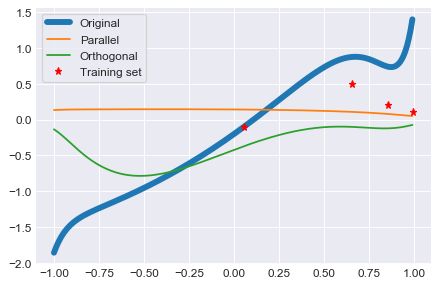

In [18]:
# Project on trainset
phi_parrallel = []
for phi_test in phi_tests:
    alphas = np.array([phi_i.T @ phi_test /(phi_i.T @ phi_i) for phi_i in  phi_train])
    y_hat_i = np.sum([alpha * theta_mn.T @ phi_i  for alpha, phi_i in zip(alphas,phi_train)])
    phi_parrallel_i = np.sum([alpha * phi_i  for alpha, phi_i in zip(alphas,phi_train)],axis=0)
    phi_parrallel.append(phi_parrallel_i)
    
# Orthogonal projection on trainset
phi_orthogonal = [phi_test.squeeze() - phi_i for phi_i, phi_test in  zip(phi_parrallel,phi_tests)]

# prediction
if is_norm_data is True:
    phi_parrallel = np.array([ phi_i /(phi_i @ phi_i.T)for phi_i in phi_parrallel])
    phi_orthogonal = np.array([ phi_i /(phi_i @ phi_i.T)for phi_i in phi_orthogonal])
    
y_hat_parallel = np.array([float(theta_mn.T @ phi_i) for phi_i in  phi_parrallel])
y_hat_orthogonal = np.array([float(theta_mn.T @ phi_i) for phi_i in  phi_orthogonal])
    
plt.plot(x_tests,y_hat,label='Original',linewidth=5.0)
plt.plot(x_tests,y_hat_parallel, label='Parallel')
plt.plot(x_tests,y_hat_orthogonal, label='Orthogonal')
plt.plot(x_train,y_train,'r*', label='Training set')
plt.legend()
plt.show()

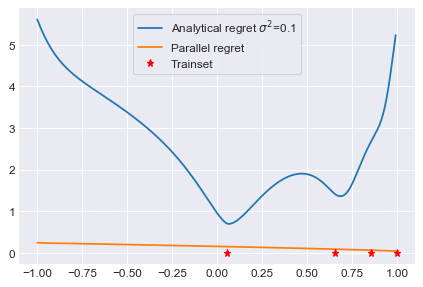

In [22]:
sigma_square = 1e-1
# Calculate analytical regret
norm_factors = [calc_analytic_norm_factor(phi_train.T, 
                                          phi_test, 
                                          theta_mn,sigma_square) for phi_test in phi_tests]
regrets = np.log(norm_factors)

# Calculate analytical regret
norm_factors = [calc_analytic_norm_factor(phi_train.T, 
                                          phi_test, 
                                          theta_mn,sigma_square) for phi_test in phi_parrallel]
regrets_parallel = np.log(norm_factors)

plt.plot(x_tests,regrets, label='Analytical regret $\sigma^2$={}'.format(sigma_square))
plt.plot(x_tests,regrets_parallel, label='Parallel regret')
plt.plot(x_train,[0]*len(y_train),'r*',label='Trainset')
plt.legend()
plt.show()

In [24]:
phi_parrallel_i, phi_test = phi_parrallel[0], phi_tests[0]
phi_parrallel_i.shape
phi_test.shape

(16, 1)

In [34]:
# Calculate projection to train subset
u,h,vh = np.linalg.svd(phi_train,full_matrices=True)
print(f'[u, h, vh]=[{u.shape} {h.shape} {vh.shape}]')
n,m = phi_train.shape # num feature, trainset size
print(f'[trainset size, num feature]=[{n} {m}]')
print(np.allclose(phi_train.T @ phi_train, u @ np.diag(h) @ vh))

h_parrallel = np.copy(h)
h_orthogonal = np.copy(h)

h_parrallel[n:] =0
h_parrallel[h_parrallel > 0] = 1
h_orthogonal[:n] = 0
h_orthogonal[h_orthogonal>0]=1


proj_mat_parallel = u @ np.diag(h_parrallel) @ vh
proj_mat_orthogonal = u @ np.diag(h_orthogonal) @ vh

y_hat_parallel = [float(theta_mn.T @ proj_mat_parallel.T @ phi_test) for phi_test in phi_tests]
y_hat_orthogonal = [float(theta_mn.T @ proj_mat_orthogonal.T @ phi_test) for phi_test in phi_tests]


[u, h, vh]=[(4, 4) (4,) (16, 16)]
[trainset size, num feature]=[4 16]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 4)

In [107]:
phi_test = phi_tests[0]

n,m = phi_train.shape # num feature, trainset size
lamb = 0.1
P_N = np.linalg.inv(phi_train.T @ phi_train + lamb * np.eye(m))
proj = float(phi_test.T @ P_N @ phi_test)
print(proj, P_N.shape)

u,h,vh = np.linalg.svd(phi_train.T, full_matrices=True)
print(f'[u, h, vh]=[{u.shape} {h.shape} {vh.shape}]')
h_mat = np.zeros((m,m))
h_mat[:n,:n] = np.diag(h)
h_mat_squre = h_mat @ h_mat.T
P_N = u @ np.linalg.inv(h_mat_squre + lamb * np.eye(m)) @ u.T
proj = float(phi_test.T @ P_N @ phi_test)
print(proj, P_N.shape)


u_parrallel = np.copy(u)
u_parrallel[:,n:] = 0
u_orthogonal = np.copy(u)
u_orthogonal[:,:n] = 0
P_N_parrallel = u_parrallel @ np.linalg.inv(h_mat_squre + lamb * np.eye(m)) @ u_parrallel.T
proj_parrallel = float(phi_test.T @ P_N_parrallel @ phi_test)
P_N_orthogonal = u_orthogonal @ np.linalg.inv(h_mat_squre + lamb * np.eye(m)) @ u_orthogonal.T
proj_orthogonal = float(phi_test.T @ P_N_orthogonal @ phi_test)
print(proj_parrallel,proj_orthogonal, P_N.shape)


79.50989522048992 (16, 16)
[u, h, vh]=[(16, 16) (4,) (4, 4)]
79.50989522049008 (16, 16)
0.6098266962573815 78.9000685242327 (16, 16)


In [135]:
u,h,vh = np.linalg.svd(phi_train.T, full_matrices=True)
u_parrallel,u_orthogonal = np.copy(u),  np.copy(u)
u_parrallel[:,n:] = 0
u_orthogonal[:,:n] = 0


phi_parrallels = [u_parrallel.T @ phi_test for phi_test in phi_tests] 
phi_orthogonals = [u_orthogonal.T @ phi_test for phi_test in phi_tests]     


y_hat_parallel = [float(theta_mn.T @ phi_test) for phi_test in phi_parrallels]
y_hat_orthogonal = [float(theta_mn.T @ phi_test) for phi_test in phi_orthogonals]


# Compute norm
norms =  np.array([float(phi_test.T @ phi_test) for phi_test in phi_tests])
parrallel_norms = np.array([float(phi_test.T @ phi_test) for phi_test in phi_parrallels])
orthogonal_norms = np.array([float(phi_test.T @ phi_test) for phi_test in phi_orthogonals]) 

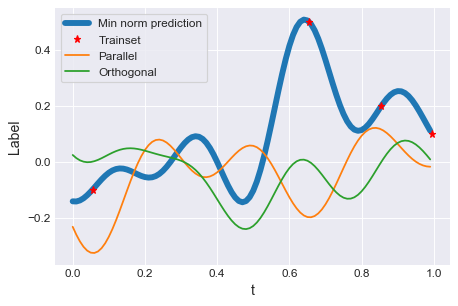

In [138]:
plt.plot(x_tests,y_hat, label='Min norm prediction', linewidth=5.0)
plt.plot(x_train,y_train,'r*', label='Trainset')
plt.plot(x_tests,y_hat_parallel,label='Parallel')
plt.plot(x_tests,y_hat_orthogonal, label='Orthogonal')
plt.legend()
plt.xlabel('t')
plt.ylabel('Label')
plt.show()

## Regret

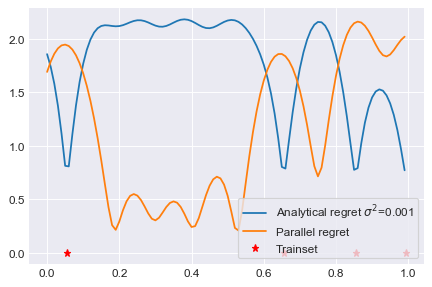

In [26]:
h_parrallel

array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
h_orthogonal

array([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [33]:
u @ u

array([[-0.47880408, -0.15019884, -0.21108725,  0.11765763,  0.06550589,
        -0.08580197,  0.16334898, -0.55325843, -0.15348771,  0.13825719,
        -0.16201143, -0.15218513, -0.32106006,  0.11872389,  0.2805163 ,
         0.2396021 ],
       [ 0.28672126,  0.08124942,  0.33851696,  0.10375649, -0.5616295 ,
         0.39922293, -0.05851974, -0.11043313,  0.07186372,  0.24435504,
        -0.09050527, -0.30542743, -0.18748962, -0.13629688,  0.18281495,
         0.20470033],
       [ 0.47013364, -0.12727473, -0.35969807, -0.02458593, -0.1617091 ,
         0.12453632,  0.18594107, -0.47453931,  0.13162036, -0.18468148,
         0.17766679, -0.0129455 ,  0.06597621,  0.35653616, -0.0198203 ,
        -0.34108589],
       [-0.00095945, -0.58233216,  0.18534227, -0.00304299, -0.06219395,
        -0.15051931,  0.01004272, -0.29496612,  0.38599678, -0.00889668,
        -0.22023585,  0.18225002,  0.19580336, -0.43429644, -0.23131256,
         0.04059408],
       [-0.18367591, -0.13932877,  0